### Import necessary package

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Load and combine price data

In [398]:
price_path = "../dataset/historicalPriceData/"
result_path = "../results/historicalPriceData/"

In [399]:


price_files = [os.path.join(price_path,f"ERCOT_DA_Prices_{i}.csv") for i in range (2016,2020)]

df_price = [pd.read_csv(file) for file in price_files]
price_combined = pd.concat(df_price, ignore_index=True)
price_combined['Date'] = pd.to_datetime(price_combined['Date'])
price_original = price_combined.copy()
price_combined

,Date,SettlementPoint,Price
0,2016-01-01 00:00:00,HB_BUSAVG,18.42
1,2016-01-01 00:00:00,HB_HOUSTON,18.42
2,2016-01-01 00:00:00,HB_HUBAVG,18.42
3,2016-01-01 00:00:00,HB_NORTH,18.43
4,2016-01-01 00:00:00,HB_SOUTH,18.38
...,...,...,...
497315,2019-12-31 23:00:00,LZ_LCRA,14.53
497316,2019-12-31 23:00:00,LZ_NORTH,14.48
497317,2019-12-31 23:00:00,LZ_RAYBN,14.48
497318,2019-12-31 23:00:00,LZ_SOUTH,14.70


In [400]:
# Check for missing values in each column
missing_values_sum = price_combined.isna().sum()
print(missing_values_sum)

Date               0
SettlementPoint    0
Price              0
dtype: int64


In [401]:
price_combined['Year'] = price_combined['Date'].dt.year
price_combined['Month'] = price_combined['Date'].dt.month
# count regions
name = price_combined['SettlementPoint'].unique()
print(len(name))

15


In [402]:
filtered_region = price_combined[price_combined['SettlementPoint'].str.startswith(('HB_', 'LZ_'))]
average_price = filtered_region.groupby(['Year','Month', 'SettlementPoint'])['Price'].mean().reset_index()
average_price.rename(columns={'Price': 'AveragePrice'}, inplace=True)

# Save results
os.makedirs(result_path, exist_ok=True)
average_price.to_csv(os.path.join(result_path, "AveragePriceByMonth.csv"), index=False)

### Price volatility
Compute hourly price1 volatility for each year and each settlement hub in the historical power price data

In [403]:
# filter hub prices and non-negative, non-zero prices
hub_price = price_combined[price_combined['SettlementPoint'].str.startswith('HB_')].copy()
hub_price.drop('Month', axis=1, inplace=True) # no need this column in results
hub_price = hub_price[hub_price['Price'] > 0]
 
# Calculate log-return
hub_price['LogReturn'] = np.log(hub_price['Price'] / hub_price['Price'].shift(1))
hub_price = hub_price.dropna(subset=['LogReturn'])
hub_price


,Date,SettlementPoint,Price,Year,LogReturn
1,2016-01-01 00:00:00,HB_HOUSTON,18.42,2016,0.000000
2,2016-01-01 00:00:00,HB_HUBAVG,18.42,2016,0.000000
3,2016-01-01 00:00:00,HB_NORTH,18.43,2016,0.000543
4,2016-01-01 00:00:00,HB_SOUTH,18.38,2016,-0.002717
5,2016-01-01 00:00:00,HB_WEST,18.44,2016,0.003259
...,...,...,...,...,...
497307,2019-12-31 23:00:00,HB_HUBAVG,14.45,2019,0.000000
497308,2019-12-31 23:00:00,HB_NORTH,14.46,2019,0.000692
497309,2019-12-31 23:00:00,HB_PAN,14.12,2019,-0.023794
497310,2019-12-31 23:00:00,HB_SOUTH,14.50,2019,0.026556


In [404]:

volatility_hub = hub_price.groupby(['Year', 'SettlementPoint'])['LogReturn'].std().reset_index()
volatility_hub.rename(columns={'LogReturn': 'HourlyVolatility'}, inplace=True)

volatility_hub.to_csv(os.path.join(result_path,"HourlyVolatilityByYear.csv"), index=False)


In [405]:
highest_volatility_df = volatility_hub.loc[volatility_hub.groupby('Year')['HourlyVolatility'].idxmax()]
highest_volatility_df.to_csv(os.path.join(result_path,"MaxVolatilityByYear.csv"), index=False)


## Data Translation and Formatting

In [406]:
price_combined

,Date,SettlementPoint,Price,Year,Month
0,2016-01-01 00:00:00,HB_BUSAVG,18.42,2016,1
1,2016-01-01 00:00:00,HB_HOUSTON,18.42,2016,1
2,2016-01-01 00:00:00,HB_HUBAVG,18.42,2016,1
3,2016-01-01 00:00:00,HB_NORTH,18.43,2016,1
4,2016-01-01 00:00:00,HB_SOUTH,18.38,2016,1
...,...,...,...,...,...
497315,2019-12-31 23:00:00,LZ_LCRA,14.53,2019,12
497316,2019-12-31 23:00:00,LZ_NORTH,14.48,2019,12
497317,2019-12-31 23:00:00,LZ_RAYBN,14.48,2019,12
497318,2019-12-31 23:00:00,LZ_SOUTH,14.70,2019,12


In [407]:
price_combined['Hour'] = price_combined['Date'].dt.hour + 1
price_combined['Date'] = price_combined['Date'].dt.date


In [408]:
transform_path = "../results/formattedSpotHistory/"
pivoted_price = price_combined.pivot_table(index=['SettlementPoint', 'Date'], columns='Hour', values='Price', aggfunc='first')
 
pivoted_price.columns = [f'X{col}' for col in pivoted_price.columns]
pivoted_df = pivoted_price.reset_index()
 
# Split the data by hub
hubs = pivoted_df['SettlementPoint'].unique()
 
# each region each price model
for hub in hubs:
    hub_df = pivoted_df[pivoted_df['SettlementPoint'] == hub].copy()
    hub_df.rename(columns={'SettlementPoint': 'Variable'}, inplace=True)
    filename = f'spot_{hub.replace(" ", "_")}.csv'
 
    # Save results
    os.makedirs(transform_path, exist_ok=True)
    hub_df.to_csv(os.path.join(transform_path, filename), index=False)

# Bonus

#### Mean Plots

In [409]:
plot_path = "../results/plot/"
mean_price = pd.read_csv("../results/historicalPriceData/AveragePriceByMonth.csv")
mean_price['Date'] = pd.to_datetime(mean_price[['Year', 'Month']].assign(DAY=1))
mean_price

,Year,Month,SettlementPoint,AveragePrice,Date
0,2016,1,HB_BUSAVG,19.209301,2016-01-01
1,2016,1,HB_HOUSTON,19.565726,2016-01-01
2,2016,1,HB_HUBAVG,19.258696,2016-01-01
3,2016,1,HB_NORTH,19.133306,2016-01-01
4,2016,1,HB_SOUTH,19.210054,2016-01-01
...,...,...,...,...,...
676,2019,12,LZ_LCRA,19.456882,2019-12-01
677,2019,12,LZ_NORTH,19.006801,2019-12-01
678,2019,12,LZ_RAYBN,19.085067,2019-12-01
679,2019,12,LZ_SOUTH,19.786882,2019-12-01


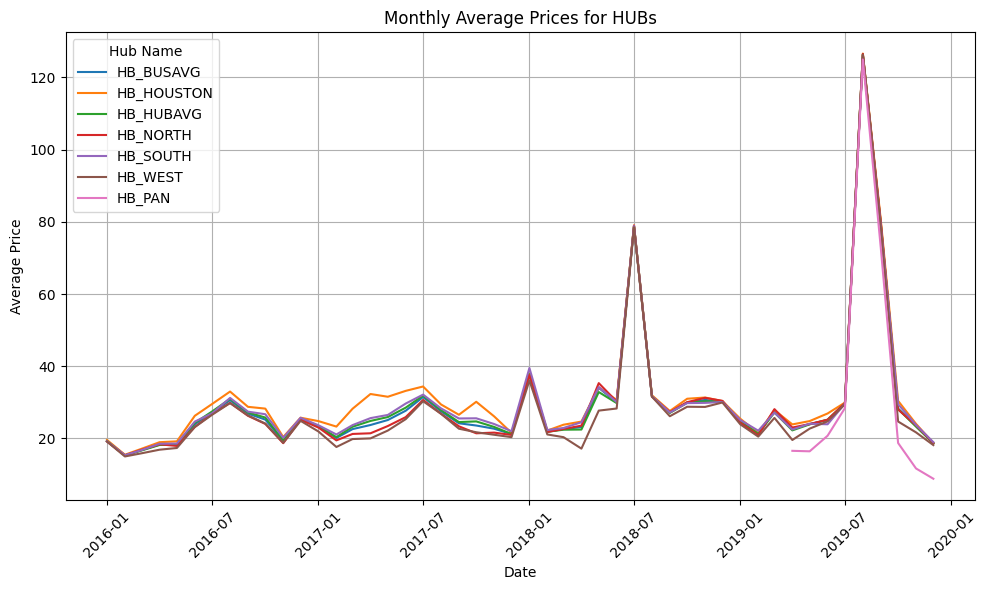

In [410]:

mean_price_HB = mean_price[mean_price['SettlementPoint'].str.startswith('HB_')]
mean_price_LZ = mean_price[mean_price['SettlementPoint'].str.startswith('LZ_')]

# Plot for SettlementHub
plt.figure(figsize=(10, 6))
for name in mean_price_HB['SettlementPoint'].unique():
    region_data = mean_price_HB[mean_price_HB['SettlementPoint'] == name]
    plt.plot(region_data['Date'], region_data['AveragePrice'], label=name)

plt.title('Monthly Average Prices for HUBs')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend(title='Hub Name')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

os.makedirs(plot_path, exist_ok=True)
plt.savefig(os.path.join(plot_path, 'SettlementHubAveragePriceByMonth.png')) 
plt.show() 

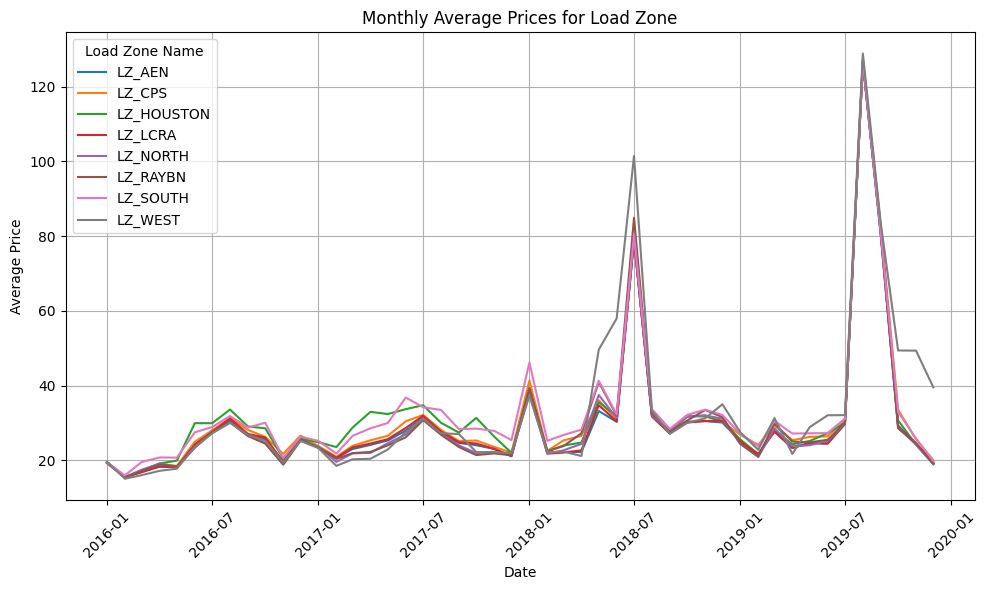

In [411]:
# Plot for LoadZone
plt.figure(figsize=(10, 6))
for name in mean_price_LZ['SettlementPoint'].unique():
    region_data = mean_price_LZ[mean_price_LZ['SettlementPoint'] == name]
    plt.plot(region_data['Date'], region_data['AveragePrice'], label=name)

plt.title('Monthly Average Prices for Load Zone')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend(title='Load Zone Name')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()


plt.savefig(os.path.join(plot_path, 'LoadZoneAveragePriceByMonth.png')) 
plt.show() 

#### Volatility Plots

In [412]:
volatility_hub = pd.read_csv("../results/historicalPriceData/HourlyVolatilityByYear.csv")
volatility_hub

,Year,SettlementPoint,HourlyVolatility
0,2016,HB_BUSAVG,0.229483
1,2016,HB_HOUSTON,0.076651
2,2016,HB_HUBAVG,0.068284
3,2016,HB_NORTH,0.061637
4,2016,HB_SOUTH,0.193588
5,2016,HB_WEST,0.236232
6,2017,HB_BUSAVG,0.341140
7,2017,HB_HOUSTON,0.155126
8,2017,HB_HUBAVG,0.134539
9,2017,HB_NORTH,0.105241


c:\python\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\python\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\python\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\python\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(

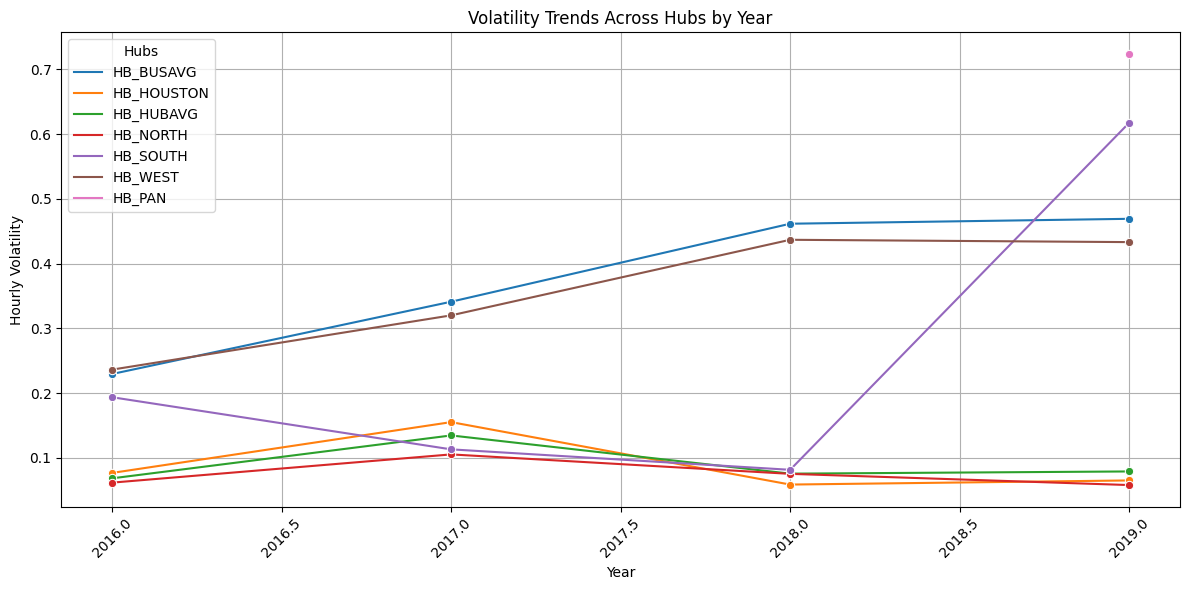

In [413]:
# Hourly Volatility Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=volatility_hub, x='Year', y='HourlyVolatility', hue='SettlementPoint', marker='o')
plt.title('Volatility Trends Across Hubs by Year')
plt.xlabel('Year')
plt.ylabel('Hourly Volatility')
plt.legend(title='Hubs')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
plt.savefig(os.path.join(plot_path, 'volatility_HB_plot.png')) 
# plt.show() 


c:\python\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\python\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\python\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\python\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', Tru

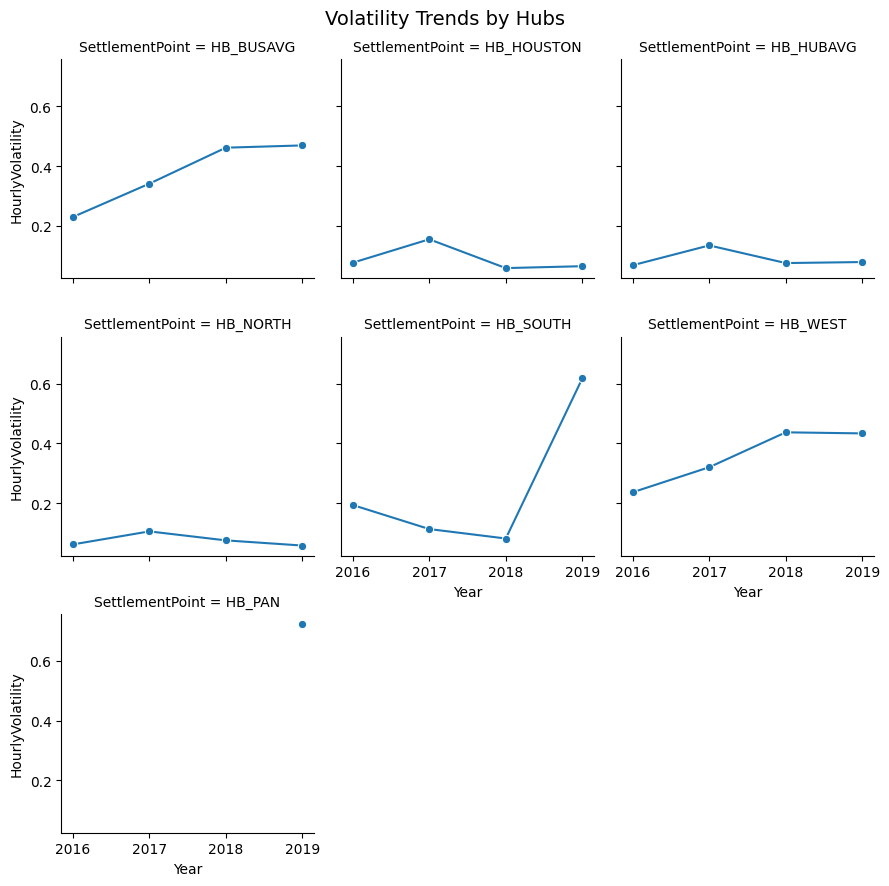

In [414]:
g = sns.FacetGrid(volatility_hub, col="SettlementPoint", col_wrap=3, sharey=True)
g.map(sns.lineplot, "Year", "HourlyVolatility", marker="o")
g.figure.suptitle("Volatility Trends by Hubs", fontsize=14)
plt.tight_layout()


g.savefig(os.path.join(plot_path, 'volatility_HB_facetgrid.png'))
#plt.show()

The chart shows yearly volatility trends across different SettlementPoints from 2016 to 2019, which shows that:

- HB_SOUTH saw a sharp spike in 2019, likely due to a major market event.
- HB_BUSAVG and HB_WEST show a steady increase, suggesting rising market fluctuations.
- HB_HOUSTON, HB_HUBAVG, HB_NORTH remain relatively stable.

In general, HB_BUSAVG and HB_WEST have higher volitility compare to all other regions

### Hourly shape

In [415]:
price_combined

,Date,SettlementPoint,Price,Year,Month,Hour
0,2016-01-01,HB_BUSAVG,18.42,2016,1,1
1,2016-01-01,HB_HOUSTON,18.42,2016,1,1
2,2016-01-01,HB_HUBAVG,18.42,2016,1,1
3,2016-01-01,HB_NORTH,18.43,2016,1,1
4,2016-01-01,HB_SOUTH,18.38,2016,1,1
...,...,...,...,...,...,...
497315,2019-12-31,LZ_LCRA,14.53,2019,12,24
497316,2019-12-31,LZ_NORTH,14.48,2019,12,24
497317,2019-12-31,LZ_RAYBN,14.48,2019,12,24
497318,2019-12-31,LZ_SOUTH,14.70,2019,12,24


In [416]:
price_combined['Date'] = pd.to_datetime(price_combined['Date'], format='%Y-%m-%d', errors='coerce')
price_combined['DayOfWeek'] = price_combined['Date'].dt.dayofweek
hourly_avg = (
    price_combined.groupby(['SettlementPoint', 'Month', 'DayOfWeek', 'Hour'])['Price']
    .mean()
    .reset_index()
)

In [417]:
def normalize_profile(group):
    return group.assign(NormalizedPrice=group['Price'] / group['Price'].sum())

hourly_shape_profiles = hourly_avg.groupby(['SettlementPoint', 'Month', 'DayOfWeek']).apply(normalize_profile)

# Drop unnecessary index created by `apply`
hourly_shape_profiles.reset_index(drop=True, inplace=True)

regions = price_combined['SettlementPoint'].unique()
hourly_path = "../results/hourlyShapeProfiles/"
for region in regions:
    region_data = hourly_shape_profiles[hourly_shape_profiles['SettlementPoint'] == region]
    filename = f'profile_{region.replace(" ", "_")}.csv'
    
    # Save the region's data to a CSV file
    os.makedirs(hourly_path, exist_ok=True)
    region_data.to_csv(os.path.join(hourly_path, filename), index=False)
  

C:\Users\lethi\AppData\Local\Temp\ipykernel_22712\1054216502.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_shape_profiles = hourly_avg.groupby(['SettlementPoint', 'Month', 'DayOfWeek']).apply(normalize_profile)


### Open-Ended Analysis

In [418]:
price_original

,Date,SettlementPoint,Price
0,2016-01-01 00:00:00,HB_BUSAVG,18.42
1,2016-01-01 00:00:00,HB_HOUSTON,18.42
2,2016-01-01 00:00:00,HB_HUBAVG,18.42
3,2016-01-01 00:00:00,HB_NORTH,18.43
4,2016-01-01 00:00:00,HB_SOUTH,18.38
...,...,...,...
497315,2019-12-31 23:00:00,LZ_LCRA,14.53
497316,2019-12-31 23:00:00,LZ_NORTH,14.48
497317,2019-12-31 23:00:00,LZ_RAYBN,14.48
497318,2019-12-31 23:00:00,LZ_SOUTH,14.70


In [419]:
def compute_statistics(df):
    summary = df.groupby("SettlementPoint")["Price"].describe()
    max_price = df.loc[df["Price"].idxmax()]
    min_price = df.loc[df["Price"].idxmin()]
    print("Summary Statistics:\n", summary)
    print(f"Highest Price Recorded: {max_price}")
    print(f"Lowest Price Recorded: {min_price}")

In [420]:
compute_statistics(price_original)

Summary Statistics:
                    count       mean         std    min      25%     50%  \
SettlementPoint                                                           
HB_BUSAVG        35060.0  29.420988   90.945900   1.18  17.9300  21.620   
HB_HOUSTON       35060.0  31.096580   91.178486   1.26  18.4600  22.700   
HB_HUBAVG        35060.0  29.512695   90.954232   1.05  17.8700  21.720   
HB_NORTH         35060.0  29.109678   91.006554   1.30  17.7600  21.300   
HB_PAN            6480.0  35.882074  191.254209 -29.98   8.9900  16.970   
HB_SOUTH         35060.0  29.897728   90.732483 -27.74  18.3100  22.185   
HB_WEST          35060.0  27.947969   91.089477  -5.98  16.8500  20.700   
LZ_AEN           35060.0  29.624877   90.947911   1.17  18.1100  21.850   
LZ_CPS           35060.0  30.844485   91.155379   1.14  18.8175  22.840   
LZ_HOUSTON       35060.0  31.530224   91.354908   1.26  18.5100  22.850   
LZ_LCRA          35060.0  29.810659   91.143627   1.15  18.1100  21.880   
LZ_N

In [9]:
df = pd.read_csv("../results/formattedSpotHistory/spot_HB_BUSAVG.csv")


hourly_prices = df.iloc[:, 2:].values  # Price of 24 hours
returns = np.diff(hourly_prices, axis=0) / hourly_prices[:-1]  # Calculate returns

# Monte Carlo simulations
num_simulations = 1000 
num_hours = 24  # Forecasting 24 hours ahead
last_prices = hourly_prices[-1]  # yesterday prices

# Run Monte Carlo simulations
simulated_prices = np.zeros((num_simulations, num_hours))
for i in range(num_simulations):
    random_returns = np.random.choice(returns.flatten(), num_hours) 
    simulated_prices[i] = last_prices * np.cumprod(1 + random_returns)  # Generate price path


simulated_prices_df = pd.DataFrame(simulated_prices)


additional_path = "../results/simulation_adding/"
filename = "simulated_prices.csv"

os.makedirs(additional_path, exist_ok=True)
simulated_prices_df.to_csv(os.path.join(additional_path, filename), index=False)
    